In [549]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as calc_eigen
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as normalize_vectors
from sklearn.model_selection import GridSearchCV as CV
import time

In [479]:
def extractTrainAndTestData(file_path, r, r2):
    """
    takes images and labels as input
    outputs training data and test data
    """
    mat = scipy.io.loadmat(file_path)
    X_train, X_test, y_train, y_test = train_test_split(mat['X'].T, mat['l'].T, test_size= r, random_state=r2, stratify = mat['l'].T)
    N_train = len(X_train[:,0])
    N_test = len(X_test[:,0])
    return X_train, y_train, N_train, X_test, y_test, N_test

def calculateAverageFace(X):
    """
    takes the training data set as input 
    and returns the average face
    """
    average_face= np.mean(X, axis=0)
    #plt.figure()
    #plt.title("Average Face")
    #plt.imshow(np.resize(average_face, (46, 56)).T, cmap='gray')
    return average_face

def normalize(X, AvgFace):
    """
    takes the training data set and average face as input 
    and returns the normalized training data set

    """
    N = len(X[:,0])
    Q = np.empty((N,2576))
    for index, face in enumerate(X):
        Q[index] = face - AvgFace
    return Q.T

def calculateCovarianceMatrix(Q):
    return np.matmul(Q,Q.T)/len(Q[0,:])

def calculateLowDimCovarianceMatrix(Q):
    return np.matmul(Q.T,Q)/len(Q[0,:])

def calculateEigenValuesAndVectors(S):
    """
    Takes covariance matrix as input
    and returns eigen values and vectors
    """
    v, w =  calc_eigen.eigh(S)
    #eigen_vectors[:,i] --> eigen_values[i]
    #eigen vector corresponding to eigen value

    #flips left to right... ascending to descending
    v = np.flip(v, axis=0) #turn ascending into descending
    w = np.flip(w, axis=1) #turn ascending into descending
    return v, w

def calculateWeights(Q, U):
    """
    takes input the normalized input and the eigen space
    outputs the weights of the normalized input
    """
    N = len(Q[0,:])
    W = np.empty((N,len(U[0, :])))
    for index, image in enumerate(Q.T):
        W[index] = np.matmul(image, U)
    return W

def calculateWeights2(Q, U):
    """
    alternative method to calculate weights
    """
    N = len(Q[0,:])
    W2 = np.empty((N,len(U[0, :])))
    W2 = np.matmul(Q.T, top_eigen_vectors)
    return W2

def printImage(face, title, saved_file):
    """
    takes input as the face you want to print, the title of the image, and the location of the file
    you would like to save the image to. 
    """
    plt.figure()
    plt.imshow(np.resize(face, (46, 56)).T, cmap='gray')
    plt.title(title)
    plt.savefig(saved_file, bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close() 
    
def plotEigenValueGraph(v, points):
    """
    plots eigen values against inrementing the number of eigen values used
    in descending order
    """
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of Eigen Values')
    plt.ylabel('Eigen Values')
    plt.title('Plot of Eigen Values in Descending Order')
    plt.plot(x_points, y_points)
    plt.savefig('eigenvalues.png', bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close()
    
def plotCumulativeEigenValueGraph(v, points):
    """
    plots cumulative variance against incrementing the number of eigenvectors used
    in descending order
    """
    plt.figure()
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of eigenfaces used (M)')
    plt.ylabel('Cumulative variance captured (in %)')
    plt.title('')
    plt.plot(x_points, y_points)
    plt.grid(b=True, which='both')
    plt.savefig('eigenvalues.png', bbox_inches='tight', dpi=300)   # save the figure to file
    plt.show()
    plt.close()

In [662]:
cumulative_eigenvalues = []
for index, eigenvalue in enumerate(EigenValues):
    cumulative_eigenvalues.append(sum(EigenValues[:index]))

#plotCumulativeEigenValueGraph(cumulative_eigenvalues/sum(EigenValues)*100, 363)
EigenValues.shape
np.linalg.norm(EigenValues_[:363] - EigenValues[:363])
np.linalg.norm(EigenSpace - EigenSpace_)


#for index, element in enumerate(EigenSpace):
#    if (np.linalg.norm(EigenSpace[index]-EigenSpace_[index])) > (10^-1):
#        #print(EigenSpace[index]-EigenSpace_[index])
#        #print((np.mean(EigenSpace[index]-EigenSpace_[index])))
#        EigenSpace_[index] = -EigenSpace_[index]

np.where(np.linalg.norm((EigenSpace - EigenSpace_), axis=0))
np.linalg.norm((EigenSpace - EigenSpace_), axis=0)
EigenSpace

array([[ 0.01394575,  0.01576243, -0.01688615, ...,  0.0281703 ,
         0.03146491, -0.02415521],
       [ 0.01571189,  0.01587948, -0.01734535, ...,  0.02163011,
         0.01280026,  0.01359372],
       [ 0.01564973,  0.01560965, -0.02025363, ..., -0.04722552,
        -0.0282348 ,  0.02912339],
       ...,
       [-0.00454921, -0.05104421,  0.00157933, ..., -0.03906536,
        -0.04576195, -0.01474584],
       [-0.00304932, -0.05122103,  0.00106444, ...,  0.03390239,
        -0.01381381, -0.00416413],
       [-0.00303724, -0.0519602 ,  0.00308547, ..., -0.02235606,
        -0.04152825,  0.01453784]])

In [647]:
EigenSpace_[np.where(np.linalg.norm((EigenSpace - EigenSpace_), axis=0)>0.5)] = -(EigenSpace_[np.where(np.linalg.norm((EigenSpace - EigenSpace_), axis=0)>0.5)])

In [460]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

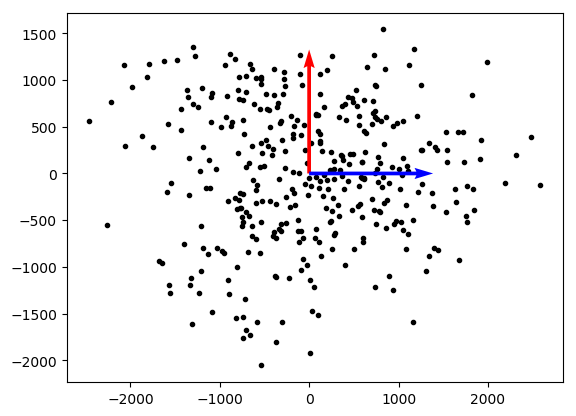

In [463]:
a1, a2, a3, a4 = calculateEigenSpace(X_train, 2)

pointss = calculateWeights(a2, a4)
plt.scatter(pointss[:,0], pointss[:,1], color='black', marker='.')
plt.quiver([0,0], [0,0], [0 ,10], [10, 0], color=['r','b'], scale=40)

#plt.tick_params(
#    axis='both',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off


plt.savefig('pca2d.png', bbox_inches='tight', dpi=300)

(364, 3)


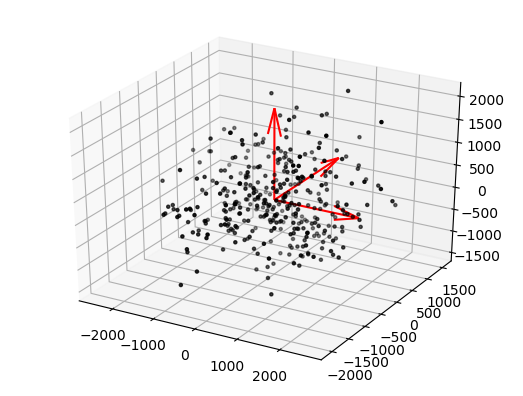

In [467]:
from mpl_toolkits.mplot3d import Axes3D

a1, a2, a3, a4 = calculateEigenSpace(X_train, 3)

np.matmul(X_train, a4)
pointss = calculateWeights(a2, a4)
print(pointss.shape)
origin = [0], [0] # origin point

#np.mean(pointss, axis=0)
#np.std(pointss, axis=0)

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointss[:,0], pointss[:,1], pointss[:,2], color='black', marker='.')

ax.quiver([0,0, 0], [0,0, 0], [0,0,0], [0 ,2000, 0], [2000, 0, 0], [0, 0, 2000], color=['r'])

In [640]:
file_path = 'face(1).mat'
M = 363
testRatio = 0.30
r2 = 73

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)

def calculateEigenSpace(X_train, M):
    AvgFace = calculateAverageFace(X_train)
    A = normalize(X_train, AvgFace)
    S = calculateLowDimCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    #print("1: ", eigen_vectors.shape)
    eigen_vectors = normalize_vectors(np.matmul(A, eigen_vectors), axis=0)
    #print("2: ", eigen_vectors.shape)
    top_eigen_vectors = eigen_vectors[:, :M]
    #print("3: ", top_eigen_vectors.shape)
    return AvgFace, A, eigen_values, top_eigen_vectors

AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M)
Weights =  calculateWeights(A, EigenSpace)

In [651]:
# this cell is for report porpuses only
file_path = 'face(1).mat'
M = 363
testRatio = 0.30
r2 = 73

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)

def calculateEigenSpace_(X_train, M):
    AvgFace = calculateAverageFace(X_train)
    A = normalize(X_train, AvgFace)
    start = time.time()
    S = calculateCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    #print("1: ", eigen_vectors.shape)
    eigen_vectors = normalize_vectors(eigen_vectors, axis=0)
    #print("2: ", eigen_vectors.shape)
    end = time.time()
    top_eigen_vectors = eigen_vectors[:, :M]
    #print("3: ", top_eigen_vectors.shape)
    timeTaken_.append(end - start)
    return AvgFace, A, eigen_values, top_eigen_vectors

def calculateEigenSpaceLowDim_(X_train, M):
    AvgFace = calculateAverageFace(X_train)
    A = normalize(X_train, AvgFace)
    start = time.time()
    S = calculateLowDimCovarianceMatrix(A)
    eigen_values, eigen_vectors = calculateEigenValuesAndVectors(S)
    #print("1: ", eigen_vectors.shape)
    eigen_vectors = normalize_vectors(np.matmul(A, eigen_vectors), axis=0)
    #print("2: ", eigen_vectors.shape)
    end = time.time()
    top_eigen_vectors = eigen_vectors[:, :M]
    #print("3: ", top_eigen_vectors.shape)
    timeTakenLowDim.append(end - start)
    return AvgFace, A, eigen_values, top_eigen_vectors

#timeTaken_ = []
#timeTakenLowDim = []

#for M in range (1, 364):
#    AvgFace_, A_, EigenValues_, EigenSpace_ = calculateEigenSpaceLowDim_(X_train, M)
#print(timeTakenLowDim)

#for M in range (1, 364):
#    AvgFace_, A_, EigenValues_, EigenSpace_ = calculateEigenSpace_(X_train, M)
#print(timeTaken_)

AvgFace_, A_, EigenValues_, EigenSpace_ = calculateEigenSpace_(X_train, M)


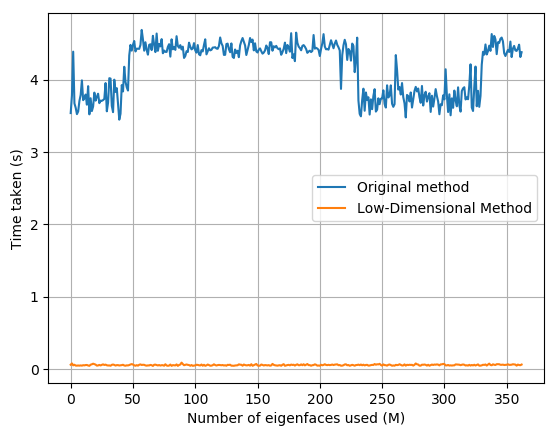

4.162052651738989 0.05238353516444687


In [581]:
len(timeTaken)
len(timeTakenLowDim)

def plotTimeTaken(v, v_lowdim, points):
    """
    plots cumulative variance against incrementing the number of eigenvectors used
    in descending order
    """
    plt.figure()
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of eigenfaces used (M)')
    plt.ylabel('Time taken (s)')
    plt.title('')
    plt.plot(x_points, y_points)
    y_points_lowdim = [value for value in v_lowdim[:points]]
    plt.plot(x_points, y_points_lowdim)
    plt.grid(b=True, which='both')
    plt.legend(['Original method', 'Low-Dimensional Method'])
    plt.savefig('timetaken.png', bbox_inches='tight', dpi=300)   # save the figure to file
    plt.show()
    plt.close()
    
plotTimeTaken(timeTaken, timeTakenLowDim, 363)
print(np.mean(timeTaken), np.mean(timeTakenLowDim))

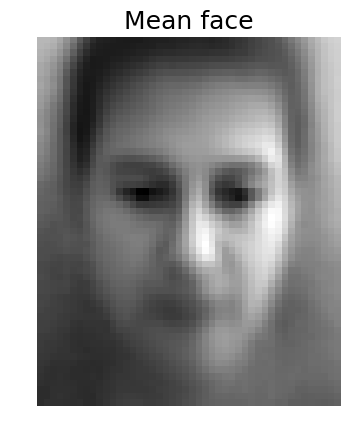

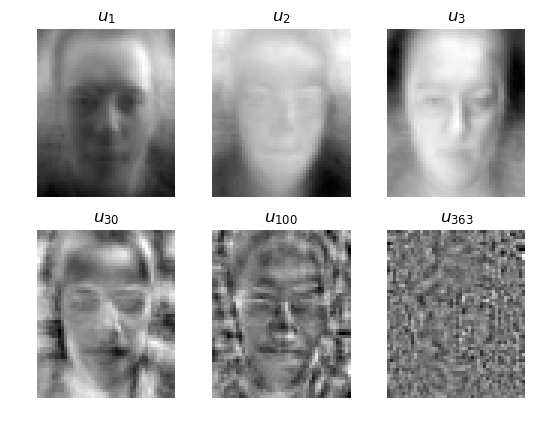

In [468]:
def print_avgface_report():
    plt.figure()
    plt.imshow(np.resize(AvgFace, (46, 56)).T, cmap='gray')
    plt.title('Mean face', size=18)
    plt.axis('off')
    plt.savefig('avgface.png', bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close()

def print_eigenfaces_report():
    face1 = np.resize(EigenSpace[:,0], (46, 56)).T
    face2 = np.resize(EigenSpace[:,1], (46, 56)).T
    face3 = np.resize(EigenSpace[:,2], (46, 56)).T
    face4 = np.resize(EigenSpace[:,29], (46, 56)).T
    face5 = np.resize(EigenSpace[:,99], (46, 56)).T
    face6 = np.resize(EigenSpace[:,362], (46, 56)).T

    fig, ax = plt.subplots(2, 3)
    
    ax[0,0].imshow(face1, cmap='gray')
    ax[0,0].set_title(r'$u_1$')
    ax[0,0].axis('off')
    
    ax[0,1].imshow(face2, cmap='gray')
    ax[0,1].set_title(r'$u_2$')
    ax[0,1].axis('off')
        
    ax[0,2].imshow(face3, cmap='gray')
    ax[0,2].set_title(r'$u_3$')
    ax[0,2].axis('off')
    
    ax[1,0].imshow(face4, cmap='gray')
    ax[1,0].set_title(r'$u_{30}$')
    ax[1,0].axis('off')
    
    ax[1,1].imshow(face5, cmap='gray')
    ax[1,1].set_title(r'$u_{100}$')
    ax[1,1].axis('off')
    
    ax[1,2].imshow(face6, cmap='gray')
    ax[1,2].set_title(r'$u_{363}$')
    ax[1,2].axis('off')
    
    plt.savefig('eigenfaces_illustration.png', bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close()

print_avgface_report()
print_eigenfaces_report()

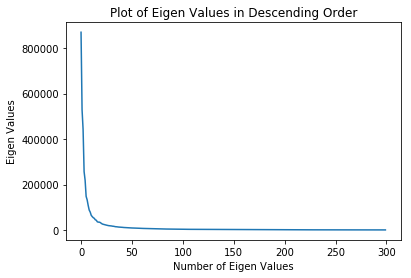

In [389]:
x_points = 300
plotEigenValueGraph(EigenValues, x_points)

In [5]:
np.sum(EigenValues[:390])*100/np.sum(EigenValues)

100.0

### Reconstruction

In [6]:
def reconstruction(weight, average_face, w):
    return (average_face + np.dot(w, weight.T))

In [7]:
# picking one face and it's corresponding weight for reconstruction
random_index = 5
face_to_be_reconstructed = X_train[random_index, :]
weights_of_face_to_be_reconstructed = Weights[random_index, :]

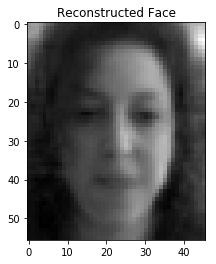

In [8]:
reconstructed_face = reconstruction(weights_of_face_to_be_reconstructed, AvgFace, EigenSpace)
#printImage(face_to_be_reconstructed, "Original Face", "original_face.png")
printImage(reconstructed_face, "Reconstructed Face", "reconstructed_face2.png")

In [9]:
error = reconstructed_face - face_to_be_reconstructed

In [10]:
calc_eigen.norm(error)

314.19223664722057

# Recognition

### NN Classification (self built functions)

In [11]:
def NNClassification(r, 
                     y_train, W_train, X_train, 
                     y_test, W_test, X_test):
    
    weight_test = W_test[r, :]
    face_test = X_test[r, :]
    face_test_label = y_test[r, :]
    error = np.empty(( len(W_train[:, 0]) ))
    for index, weight in enumerate(W_train): 
        error[index] = calc_eigen.norm(weight_test - weight)
    min_error = error.min()
    min_error_index = error.argmin()
    face_best_matched = X_train[min_error_index, :]
    label_best_matched = y_train[min_error_index, :]
    print(face_test_label, '--->', label_best_matched)
    if label_best_matched != face_test_label:
        return 1
    else:
        return 0

In [12]:
A_test = normalize(X_test, AvgFace) #normalize the test data
W_test = calculateWeights(A_test, EigenSpace) #calculate weights of the test data 
totalErrors = 0
for r in range(N_test):
    totalErrors += NNClassification(r, y_train, Weights, X_train, y_test, W_test, X_test)
E_out = totalErrors/N_test
print(E_out*100)

[8] ---> [8]
[45] ---> [5]
[32] ---> [32]
[42] ---> [16]
[41] ---> [40]
[45] ---> [45]
[43] ---> [36]
[22] ---> [12]
[42] ---> [42]
[50] ---> [50]
[11] ---> [30]
[26] ---> [26]
[40] ---> [35]
[19] ---> [24]
[30] ---> [17]
[49] ---> [6]
[47] ---> [44]
[28] ---> [46]
[1] ---> [1]
[18] ---> [20]
[27] ---> [29]
[36] ---> [48]
[14] ---> [14]
[48] ---> [41]
[17] ---> [17]
[6] ---> [10]
[38] ---> [49]
[39] ---> [39]
[3] ---> [3]
[45] ---> [45]
[15] ---> [15]
[21] ---> [21]
[13] ---> [13]
[27] ---> [27]
[9] ---> [9]
[18] ---> [18]
[47] ---> [21]
[16] ---> [16]
[33] ---> [33]
[18] ---> [18]
[32] ---> [49]
[7] ---> [1]
[37] ---> [37]
[20] ---> [20]
[2] ---> [5]
[19] ---> [4]
[33] ---> [33]
[44] ---> [29]
[2] ---> [32]
[2] ---> [5]
[13] ---> [19]
[52] ---> [52]
[52] ---> [52]
[34] ---> [40]
[3] ---> [3]
[10] ---> [10]
[48] ---> [48]
[9] ---> [9]
[15] ---> [21]
[24] ---> [24]
[51] ---> [51]
[26] ---> [26]
[16] ---> [16]
[9] ---> [9]
[29] ---> [21]
[51] ---> [25]
[6] ---> [6]
[23] ---> [23]
[21] --

In [13]:
len(EigenSpace[0, :])

100

### NN Classification #2 (Inbuilt Functions Used)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

In [15]:
def NNClassification(file_path, testRatio, M, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    neigh = KNeighborsClassifier(n_neighbors = 1)
    #preparing the training data
    AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M) #calculating eigen space
    W_train =  calculateWeights(A, EigenSpace) #calculating the weights of training set using eigen space
    #preparing the test data
    A_test = normalize(X_test, AvgFace) #normalize the test data
    W_test = calculateWeights(A_test, EigenSpace) #calculate weights of the test data 
    neigh.fit(W_train, y_train) 
    neigh.predict(W_test)
    return neigh.score(W_test, y_test)

In [664]:
file_path = 'face(1).mat'
M = [1, 3, 5, 10, 50, 100, 200, 300, 363]
testRatio = 0.30
r2 = 73
for m_val in M:
    acc = NNClassification(file_path, testRatio, m_val, r2)
    print("Accuracy for: ", m_val, " is: " , acc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Accuracy for:  1  is:  0.07051282051282051
Accuracy for:  3  is:  0.14743589743589744
Accuracy for:  5  is:  0.3076923076923077
Accuracy for:  10  is:  0.46794871794871795
Accuracy for:  50  is:  0.6346153846153846
Accuracy for:  100  is:  0.6153846153846154
Accuracy for:  200  is:  0.6282051282051282
Accuracy for:  300  is:  0.6346153846153846
Accuracy for:  363  is:  0.6410256410256411


[0.2880086898803711,
 0.22833728790283203,
 0.21893572807312012,
 0.23869609832763672,
 0.402360200881958,
 2.118631601333618,
 3.780596971511841,
 5.24053955078125,
 6.365015983581543]

In [678]:
# for report purposes only

file_path = 'face(1).mat'
M = [1, 3, 5, 10, 50, 100, 200, 300, 363]
testRatio = 0.30
r2 = 73
totalTimes = []
for m_val in range(1, 364):
    start = time.time()
    acc = NNClassification(file_path, testRatio, m_val, r2)
    end = time.time()
    totalTimes.append(end - start)
    print("Accuracy for: ", m_val, " is: " , acc)
totalTimes

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


Accuracy for:  1  is:  0.07051282051282051
Accuracy for:  2  is:  0.12179487179487179
Accuracy for:  3  is:  0.14743589743589744
Accuracy for:  4  is:  0.23076923076923078
Accuracy for:  5  is:  0.3076923076923077
Accuracy for:  6  is:  0.3525641025641026
Accuracy for:  7  is:  0.33974358974358976
Accuracy for:  8  is:  0.40384615384615385
Accuracy for:  9  is:  0.44871794871794873
Accuracy for:  10  is:  0.46794871794871795
Accuracy for:  11  is:  0.46153846153846156
Accuracy for:  12  is:  0.46794871794871795
Accuracy for:  13  is:  0.47435897435897434
Accuracy for:  14  is:  0.48717948717948717
Accuracy for:  15  is:  0.5128205128205128
Accuracy for:  16  is:  0.5128205128205128
Accuracy for:  17  is:  0.5064102564102564
Accuracy for:  18  is:  0.5256410256410257
Accuracy for:  19  is:  0.5192307692307693
Accuracy for:  20  is:  0.5128205128205128
Accuracy for:  21  is:  0.532051282051282
Accuracy for:  22  is:  0.5384615384615384
Accuracy for:  23  is:  0.5576923076923077
Accuracy 

Accuracy for:  190  is:  0.6346153846153846
Accuracy for:  191  is:  0.6282051282051282
Accuracy for:  192  is:  0.6282051282051282
Accuracy for:  193  is:  0.6282051282051282
Accuracy for:  194  is:  0.6346153846153846
Accuracy for:  195  is:  0.6282051282051282
Accuracy for:  196  is:  0.6282051282051282
Accuracy for:  197  is:  0.6282051282051282
Accuracy for:  198  is:  0.6282051282051282
Accuracy for:  199  is:  0.6282051282051282
Accuracy for:  200  is:  0.6282051282051282
Accuracy for:  201  is:  0.6282051282051282
Accuracy for:  202  is:  0.6217948717948718
Accuracy for:  203  is:  0.6217948717948718
Accuracy for:  204  is:  0.6217948717948718
Accuracy for:  205  is:  0.6282051282051282
Accuracy for:  206  is:  0.6217948717948718
Accuracy for:  207  is:  0.6282051282051282
Accuracy for:  208  is:  0.6282051282051282
Accuracy for:  209  is:  0.6282051282051282
Accuracy for:  210  is:  0.6282051282051282
Accuracy for:  211  is:  0.6282051282051282
Accuracy for:  212  is:  0.62820

[0.24077391624450684,
 0.2061023712158203,
 0.21497082710266113,
 0.22438287734985352,
 0.23414993286132812,
 0.22968292236328125,
 0.28231167793273926,
 0.24471545219421387,
 0.24254465103149414,
 0.23294353485107422,
 0.23554039001464844,
 0.2083446979522705,
 0.2456221580505371,
 0.25037622451782227,
 0.2649695873260498,
 0.25275444984436035,
 0.25283050537109375,
 0.2516937255859375,
 0.2701406478881836,
 0.26311564445495605,
 0.2594339847564697,
 0.31462836265563965,
 0.2900702953338623,
 0.3220391273498535,
 0.2797420024871826,
 0.2957420349121094,
 0.30356788635253906,
 0.30895495414733887,
 0.333723783493042,
 0.38396525382995605,
 0.31464052200317383,
 0.30635881423950195,
 0.32097935676574707,
 0.27277398109436035,
 0.3463923931121826,
 0.3518857955932617,
 0.38423705101013184,
 0.3667891025543213,
 0.3618605136871338,
 0.33762049674987793,
 0.3503530025482178,
 0.3622424602508545,
 0.45892930030822754,
 0.37744617462158203,
 0.39152979850769043,
 0.4530060291290283,
 0.41676

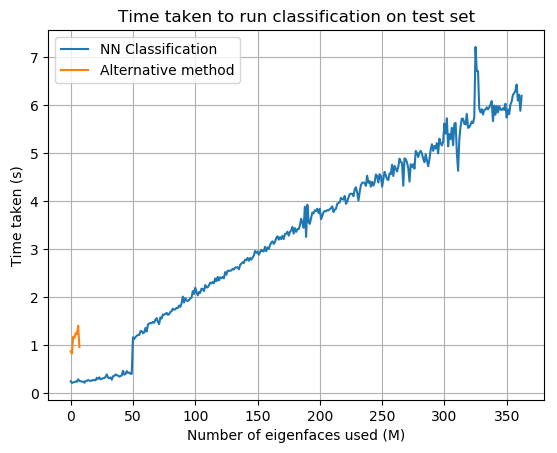

In [683]:
def plottotalTimes(v, v_alt, points):
    """
    plots cumulative variance against incrementing the number of eigenvectors used
    in descending order
    """
    plt.figure()
    y_points = [value for value in v[:points]]
    x_points = [i for i in range(points)]
    plt.xlabel('Number of eigenfaces used (M)')
    plt.ylabel('Time taken (s)')
    plt.title('Time taken to run classification on test set')
    plt.plot(x_points, y_points)
    y_alt = [value for value in v_alt[:points]]
    x_alt = [i for i in range(8)]
    plt.plot(x_alt, y_alt)
    plt.grid(b=True, which='both')
    plt.legend(['NN Classification', 'Alternative method'])
    plt.savefig('nnclassificationtime.png', bbox_inches='tight', dpi=300)   # save the figure to file
    plt.show()
    plt.close()
    
plottotalTimes(totalTimes, timeTakenAlt, 363)

### Alternative Recognition

In [17]:
def AlternativeMethod(file_path, M, testRatio, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    noOfClasses = 52
    reconstrErrors = np.empty((N_test, noOfClasses))
    d = {}

    for i in range(1, noOfClasses+1): #for each class    
        d["X_train_" + str(i)] = X_train[np.where(y_train == i)[0]]
        N = len(d["X_train_" + str(i)][:,0])
        #print("shape: ", d["X_train_" + str(i)].shape)
        AvgFace, normalized_Input, EigenValues, topEigenVectors = calculateEigenSpace(d["X_train_" + str(i)], M)
        #weights = calculateWeights(M, normalized_Input, topEigenVectors)
        weight_test = np.matmul(normalize(X_test, AvgFace).T, topEigenVectors)
        #print(topEigenVectors.shape)
        for index, weight in enumerate(weight_test):
            reconstructed_face = AvgFace + np.dot(topEigenVectors, weight.T)
            reconstruction_error = calc_eigen.norm(X_test[index] - reconstructed_face)
            reconstrErrors[index, i-1] = reconstruction_error 
            
    total_error = 0
    for index, face in enumerate(reconstrErrors):
        original_class = y_test[index, :]
        min_error = face.min()
        min_error_index = face.argmin()
        #print(original_class, '-->', min_error_index+1)
        class_matched = min_error_index+1
        if original_class != class_matched:
            total_error +=1
            
    return 100 - (total_error*100/N_test)

In [671]:
file_path = 'face(1).mat'
M = [1, 2, 3, 4, 5, 6, 7]
for m_val in M: 
    acc = AlternativeMethod(file_path, m_val, testRatio, r2)
    print("Accuracy for: ", m_val, " is: " , acc)

Accuracy for:  1  is:  57.69230769230769
Accuracy for:  2  is:  67.94871794871796
Accuracy for:  3  is:  71.7948717948718
Accuracy for:  4  is:  71.7948717948718
Accuracy for:  5  is:  71.15384615384616
Accuracy for:  6  is:  70.51282051282051
Accuracy for:  7  is:  73.07692307692308


In [676]:
#for report purposes only

file_path = 'face(1).mat'
M = [0, 1, 2, 3, 4, 5, 6, 7]
timeTakenAlt = []
for m_val in M: 
    start = time.time()
    acc = AlternativeMethod(file_path, m_val, testRatio, r2)
    end = time.time()
    timeTakenAlt.append(end-start)
    #print("Accuracy for: ", m_val, " is: " , acc)
timeTakenAlt

[0.8659121990203857,
 0.8167283535003662,
 1.1711814403533936,
 1.1445910930633545,
 1.24664306640625,
 1.2217600345611572,
 1.400803565979004,
 0.9510650634765625]

# LDA-PCA

In [1118]:
def compute_class_means():
    class_means={} #dict containing m1, m2, m3, ... (the mean of each class), as well as the global mean m
    for class_i in range(1, 53):
        class_means["m_" + str(class_i)] = np.mean(X_train[np.where(y_train == class_i)[0]], axis=0)
    class_means["m"] = calculateAverageFace(X_train)
    return class_means

def compute_S_b(class_means, M_pca):
    S_b = np.empty((2576, 2576))
    for class_i in range(1, 53):
        S_b += np.dot((class_means["m_" + str(class_i)] - class_means["m"]).reshape(2576,1), (class_means["m_" + str(class_i)] - class_means["m"]).reshape((1, 2576)))
    return S_b

def compute_S_w(class_means, M_pca):
    S_w = np.empty((2576, 2576))
    for class_i in range(1, 53):
        for image in X_train[np.where(y_train == class_i)[0]]:
            S_w += np.dot((image - class_means["m_" + str(class_i)]).reshape(2576,1), (image - class_means["m_" + str(class_i)]).reshape(1,2576))
    return S_w

def calculateGeneralisedEigenvectors(denominator, numerator, M):
    V, W = calculateEigenValuesAndVectors(np.matmul(np.linalg.inv(denominator), numerator))
    #plotEigenValueGraph(eigen_values, 100)
    W = normalize_vectors(W, axis=0)
    W = W[:, :M]
    return W

def NNClassification_weights(W_train, W_test, y_train, y_test):
    neigh = KNeighborsClassifier(n_neighbors = 1)
    neigh.fit(W_train, y_train) 
    neigh.predict(W_test)
    return neigh

In [155]:
def PCA_LDA(file_path, testRatio, M_pca, M_lda, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    #W_pca
    AvgFace, A_train, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
    W_pca = EigenSpace
    
    #calculate S_w and S_b
    class_means = compute_class_means()
    S_b = compute_S_b(class_means, M_pca)
    S_w = compute_S_w(class_means, M_pca)
    #W_lda
    W_lda = calculateGeneralisedEigenvectors(np.linalg.multi_dot([W_pca.T, S_w, W_pca]), np.linalg.multi_dot([W_pca.T, S_b, W_pca]), M_lda)
    
    #W_opt
    W_opt = np.matmul(W_lda.T, W_pca.T).T
    
    A_test = normalize(X_test, AvgFace)
    #Classification
    W_train = np.matmul(A_train.T, W_opt) #calculate weights of training data
    W_test = np.dot(A_test.T, W_opt) #calculate weights of the test data 
    print(len(y_train), W_train.shape)
    neigh = NNClassification_weights(W_train, W_test, y_train, y_test)
    acc = neigh.score(W_test, y_test)
    return acc

In [896]:
def PCA_LDA_(file_path, testRatio, M_pca, M_lda, r2):
    X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    #W_pca
    AvgFace, A_train, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
    W_pca = EigenSpace
    
    #calculate S_w and S_b
    #class_means = compute_class_means()
    #S_b = compute_S_b(class_means, M_pca)
    #S_w = compute_S_w(class_means, M_pca)
    #W_lda
    W_lda = calculateGeneralisedEigenvectors(np.linalg.multi_dot([W_pca.T, S_w, W_pca]), np.linalg.multi_dot([W_pca.T, S_b, W_pca]), M_lda)
    
    #W_opt
    W_opt = np.matmul(W_lda.T, W_pca.T).T
    
    A_test = normalize(X_test, AvgFace)
    #Classification
    W_train = np.matmul(A_train.T, W_opt) #calculate weights of training data
    W_test = np.dot(A_test.T, W_opt) #calculate weights of the test data 
    #print(len(y_train), W_train.shape)
    neigh = NNClassification_weights(W_train, W_test, y_train, y_test)
    acc = neigh.score(W_test, y_test)
    return acc

In [851]:
file_path = 'face(1).mat'
M_pca = 150
testRatio = 0.30
M_lda = 51
random_state = 73


acc = PCA_LDA(file_path, testRatio, M_pca, M_lda, random_state)
acc

364 (364, 51)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7435897435897436

In [990]:
results = []
class_means = compute_class_means()
S_b = compute_S_b(class_means, M_pca)
S_w = compute_S_w(class_means, M_pca)

for M_pca in range(1, 364, 1):
    print('current M_pca:', M_pca)
    for M_lda in range(1, 52, 1):
        start = time.time()
        acc = PCA_LDA_(file_path, testRatio, M_pca, M_lda, random_state)
        end = time.time()
        #print("M_pca: ", M_pca, " & M_lda: ", M_lda, " return accuracy: ", acc, "time taken:", end-start)
        results.append([M_pca, M_lda, acc*100])
        
results = np.array(results)

current M_pca: 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


current M_pca: 2
current M_pca: 3
current M_pca: 4
current M_pca: 5
current M_pca: 6
current M_pca: 7
current M_pca: 8
current M_pca: 9
current M_pca: 10
current M_pca: 11
current M_pca: 12
current M_pca: 13
current M_pca: 14
current M_pca: 15
current M_pca: 16
current M_pca: 17
current M_pca: 18
current M_pca: 19
current M_pca: 20
current M_pca: 21
current M_pca: 22
current M_pca: 23
current M_pca: 24
current M_pca: 25
current M_pca: 26
current M_pca: 27
current M_pca: 28
current M_pca: 29
current M_pca: 30
current M_pca: 31
current M_pca: 32
current M_pca: 33
current M_pca: 34
current M_pca: 35
current M_pca: 36
current M_pca: 37
current M_pca: 38
current M_pca: 39
current M_pca: 40
current M_pca: 41
current M_pca: 42
current M_pca: 43
current M_pca: 44
current M_pca: 45
current M_pca: 46
current M_pca: 47
current M_pca: 48
current M_pca: 49
current M_pca: 50
current M_pca: 51
current M_pca: 52
current M_pca: 53
current M_pca: 54
current M_pca: 55
current M_pca: 56
current M_pca: 57


394922956080

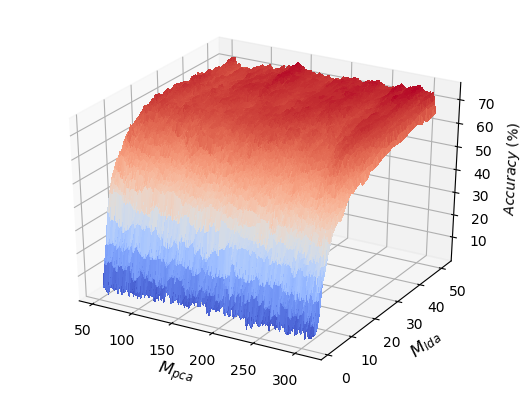

array([[  1.        ,   1.        ,   7.05128205],
       [  1.        ,   2.        ,   7.05128205],
       [  1.        ,   3.        ,   7.05128205],
       ...,
       [363.        ,  49.        ,  60.8974359 ],
       [363.        ,  50.        ,  60.8974359 ],
       [363.        ,  51.        ,  60.8974359 ]])

In [1165]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot3dresults(results):
    results = np.array(results)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    X = results[:,0]
    Y = results[:,1]
    #X, Y = np.meshgrid(X, Y)
    #X = X.reshape(16, 51).T
    #Y = Y.reshape(16, 51).T
    Z = results[:,2]
    #Z = Z.reshape(16,51).T
    
    # Plot the surface.
    surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=10, antialiased=False)

    # Customize the z axis.
    #ax.set_zlim(-1.01, 1.01)
    #ax.zaxis.set_major_locator(LinearLocator(10))
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    
    #fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel('$M_{pca}$', fontsize=12)
    ax.set_ylabel('$M_{lda}$', fontsize=12)
    ax.set_zlabel('$Accuracy\ (\%)$', fontsize=10)
    ax.view_init(30, -60)
    plt.savefig('PCALDAhyperparameters.png', bbox_inches='tight', dpi=300)
    plt.show()
    
plot3dresults(newpoints)


results

In [1164]:
np.argmax(results[:,2])
newpoints = results[np.where((results[:,0]<313) & (results[:,0]>51))]

In [1163]:
results[np.where((results[:,0]==312) & (results[:,1] == 51))]

array([[312.        ,  51.        ,  65.38461538]])

In [987]:
results[np.where(results[:,0]==60)]
#np.argmax(results[:,2])
#results[298]

array([[6.00000000e+01, 1.00000000e+00, 5.12820513e-02],
       [6.00000000e+01, 2.00000000e+00, 1.53846154e-01],
       [6.00000000e+01, 3.00000000e+00, 2.30769231e-01],
       [6.00000000e+01, 4.00000000e+00, 3.46153846e-01],
       [6.00000000e+01, 5.00000000e+00, 4.42307692e-01],
       [6.00000000e+01, 6.00000000e+00, 4.48717949e-01],
       [6.00000000e+01, 7.00000000e+00, 4.87179487e-01],
       [6.00000000e+01, 8.00000000e+00, 5.70512821e-01],
       [6.00000000e+01, 9.00000000e+00, 5.83333333e-01],
       [6.00000000e+01, 1.00000000e+01, 5.57692308e-01],
       [6.00000000e+01, 1.10000000e+01, 5.83333333e-01],
       [6.00000000e+01, 1.20000000e+01, 6.47435897e-01],
       [6.00000000e+01, 1.30000000e+01, 6.15384615e-01],
       [6.00000000e+01, 1.40000000e+01, 6.53846154e-01],
       [6.00000000e+01, 1.50000000e+01, 6.28205128e-01],
       [6.00000000e+01, 1.60000000e+01, 6.41025641e-01],
       [6.00000000e+01, 1.70000000e+01, 6.47435897e-01],
       [6.00000000e+01, 1.80000

In [943]:
x = np.linspace(60, 360, 301)
y = np.linspace(1, 50, 50)

X, Y = np.meshgrid(x, y)
#X.shape
Y

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 3.,  3.,  3., ...,  3.,  3.,  3.],
       ...,
       [48., 48., 48., ..., 48., 48., 48.],
       [49., 49., 49., ..., 49., 49., 49.],
       [50., 50., 50., ..., 50., 50., 50.]])

In [964]:
X = results[:,0]
Y = results[:,1]
X = X.reshape(16, 51).T
Y = Y.reshape(16, 51).T
Z = results[:,2]
Z = Z.reshape(16,51).T
#Z[296:305]
Z

array([[0.05128205, 0.04487179, 0.03205128, 0.05128205, 0.04487179,
        0.03846154, 0.07692308, 0.07692308, 0.07051282, 0.03846154,
        0.05769231, 0.03846154, 0.05128205, 0.03846154, 0.05769231,
        0.03205128],
       [0.15384615, 0.1474359 , 0.14102564, 0.11538462, 0.12179487,
        0.07692308, 0.12179487, 0.17307692, 0.13461538, 0.16025641,
        0.08333333, 0.08974359, 0.1025641 , 0.07692308, 0.11538462,
        0.08333333],
       [0.23076923, 0.21794872, 0.19871795, 0.21794872, 0.21153846,
        0.18589744, 0.18589744, 0.20512821, 0.21794872, 0.21794872,
        0.21153846, 0.19871795, 0.20512821, 0.1025641 , 0.16666667,
        0.17948718],
       [0.34615385, 0.31410256, 0.33333333, 0.30769231, 0.30128205,
        0.25      , 0.28846154, 0.33333333, 0.32692308, 0.30769231,
        0.29487179, 0.25641026, 0.28205128, 0.25      , 0.23717949,
        0.23076923],
       [0.44230769, 0.39102564, 0.35897436, 0.3974359 , 0.40384615,
        0.35897436, 0.3974359 , 

In [906]:
results[:,2]

array([0.03846154, 0.07692308, 0.18589744, ..., 0.72435897, 0.73076923,
       0.72435897])

In [889]:
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

Z

array([[ 0.70886129,  0.57562789,  0.42921793, ...,  0.27541086,
         0.42921793,  0.57562789],
       [ 0.57562789,  0.4208019 ,  0.2570234 , ...,  0.09046523,
         0.2570234 ,  0.4208019 ],
       [ 0.42921793,  0.2570234 ,  0.08068791, ..., -0.09334004,
         0.08068791,  0.2570234 ],
       ...,
       [ 0.27541086,  0.09046523, -0.09334004, ..., -0.26940744,
        -0.09334004,  0.09046523],
       [ 0.42921793,  0.2570234 ,  0.08068791, ..., -0.09334004,
         0.08068791,  0.2570234 ],
       [ 0.57562789,  0.4208019 ,  0.2570234 , ...,  0.09046523,
         0.2570234 ,  0.4208019 ]])

In [895]:
results.shape

AttributeError: 'list' object has no attribute 'shape'

### Cross Validation

In [856]:
M_pca = [130, 140, 150, 160, 170, 180]
M_lda = 51

#for pca, lda in zip(M_pca, M_lda):
for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda, random_state)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

364 (364, 51)
M_pca:  130  & M_lda:  51  return accuracy:  0.717948717948718


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


364 (364, 51)
M_pca:  140  & M_lda:  51  return accuracy:  0.7243589743589743
364 (364, 51)
M_pca:  150  & M_lda:  51  return accuracy:  0.7435897435897436


KeyboardInterrupt: 

In [25]:
M_pca = [175, 190, 200, 210, 225]
M_lda = 51

#for pca, lda in zip(M_pca, M_lda):
for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda, random_state)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


M_pca:  175  & M_lda:  51  return accuracy:  0.7243589743589743
M_pca:  190  & M_lda:  51  return accuracy:  0.7115384615384616
M_pca:  200  & M_lda:  51  return accuracy:  0.7307692307692307
M_pca:  210  & M_lda:  51  return accuracy:  0.7307692307692307
M_pca:  225  & M_lda:  51  return accuracy:  0.7243589743589743


In [ ]:
M_pca = [100, 120, 130, 140, 150, 170, 200]
M_lda = 51
testRatio = 0.30

for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

In [ ]:
M_pca = [100, 120, 130, 140, 150, 170, 200]
M_lda = 45
testRatio = 0.30

for pca in M_pca:
    #M_lda = [int(pca*0.25), int(pca*0.5), int(pca*0.75)]
    acc = PCA_LDA(file_path, testRatio, pca, M_lda)
    print("M_pca: ", pca, " & M_lda: ", M_lda, " return accuracy: ",acc)

### ------------------------------------------------------------------------------------------------------------------------------------

### Part 1: PCA

In [784]:
#calculate the eigen space for training set using PCA (W_pca = EigenSpace)
AvgFace, A, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
W_pca = EigenSpace

### Part 2: LDA

In [785]:
#calculate S_w and S_b
class_means = compute_class_means()
S_b = compute_S_b(class_means, M_pca)
S_w = compute_S_w(class_means, M_pca)

### Part 3: Combining PCA with LDA

In [786]:
#computation of W_pca.T*S_b*W_pca
numerator = np.linalg.multi_dot([W_pca.T, S_b, W_pca])

In [787]:
#computation of W_pca.T*S_w*W_pca
denominator = np.linalg.multi_dot([W_pca.T, S_w, W_pca])

In [788]:
W_lda = calculateGeneralisedEigenvectors(denominator, numerator, M_lda)

### 4. Calculating W_opt

In [789]:
W_opt = np.matmul(W_lda.T, W_pca.T).T

In [790]:
W_opt.shape

(2576, 51)

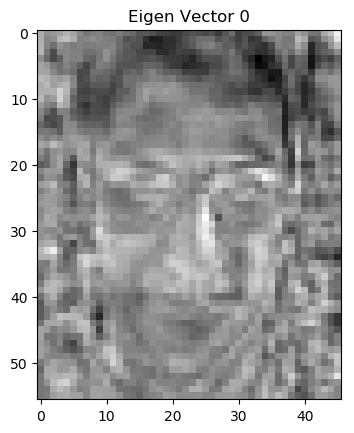

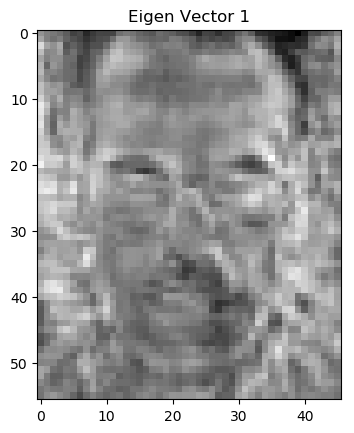

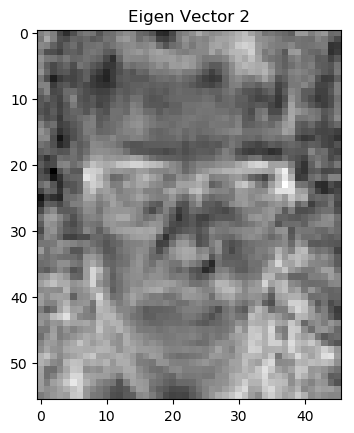

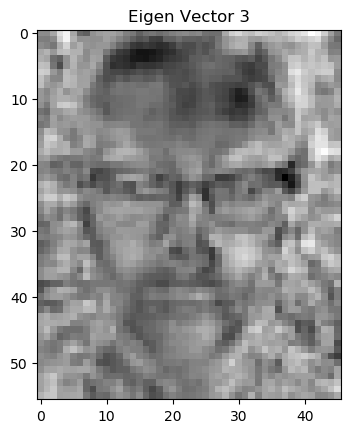

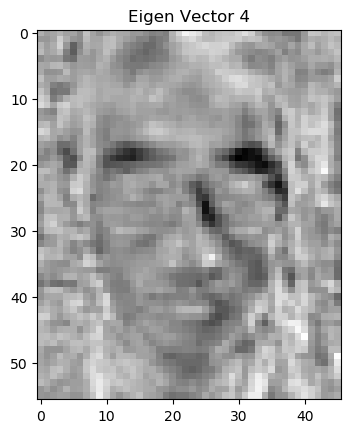

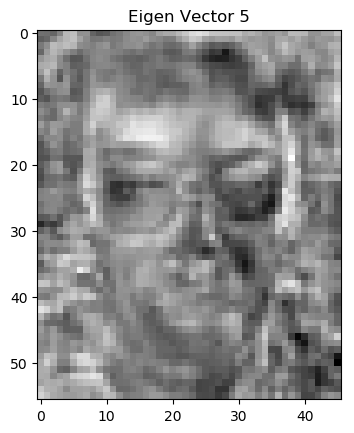

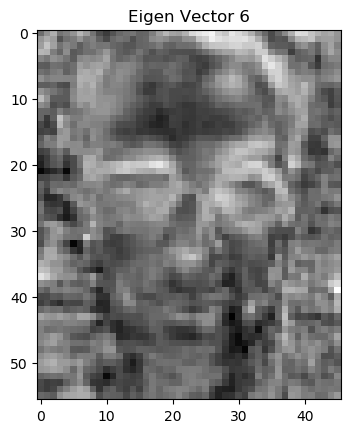

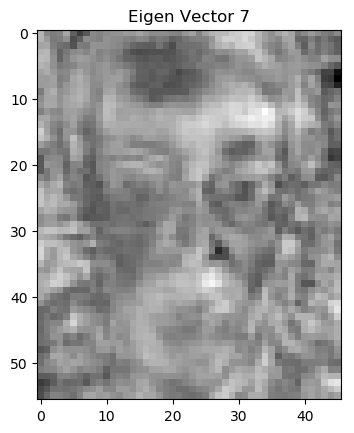

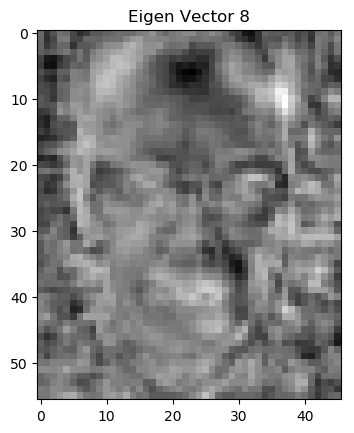

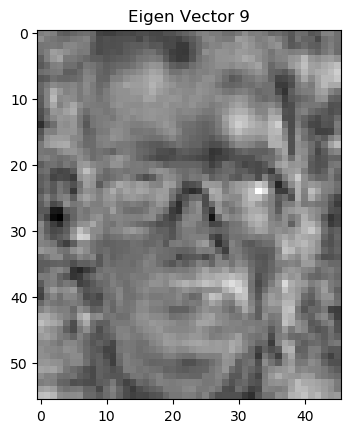

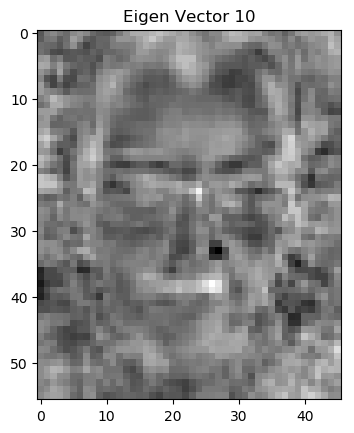

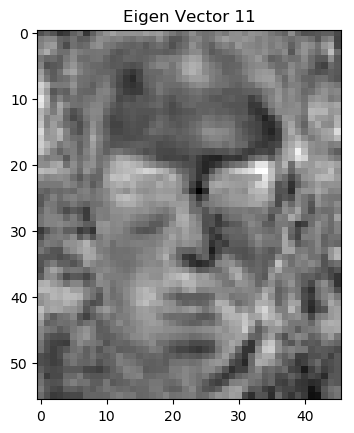

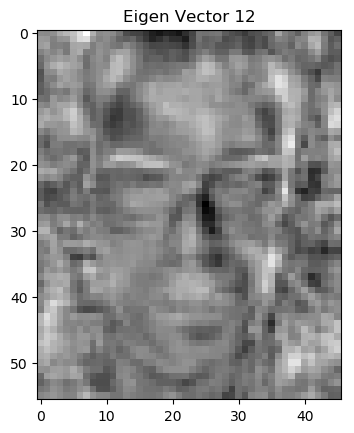

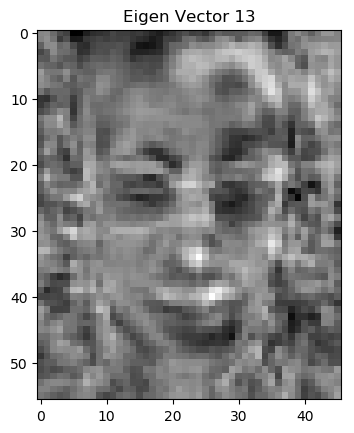

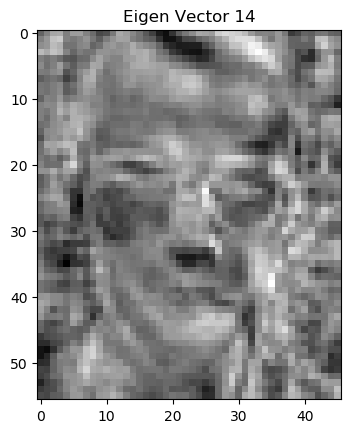

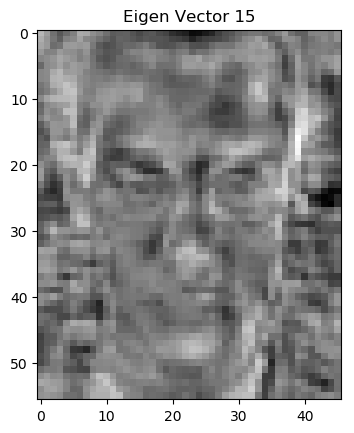

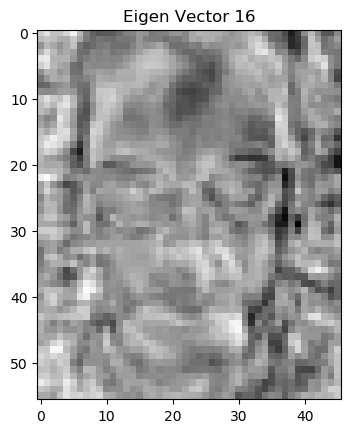

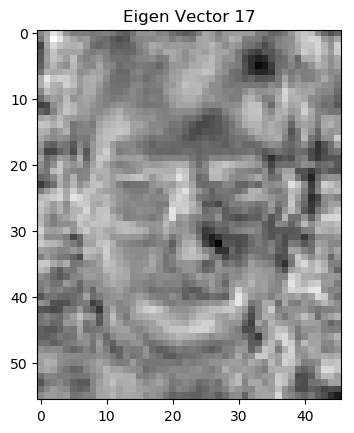

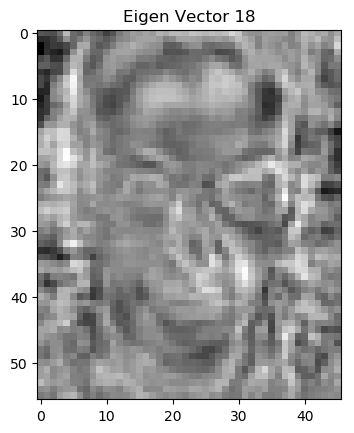

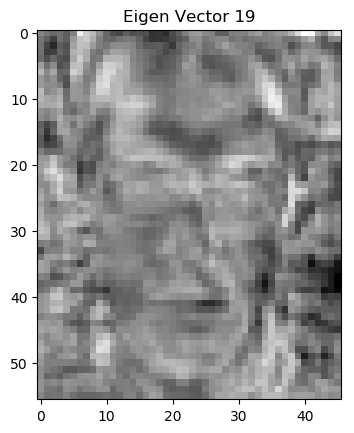

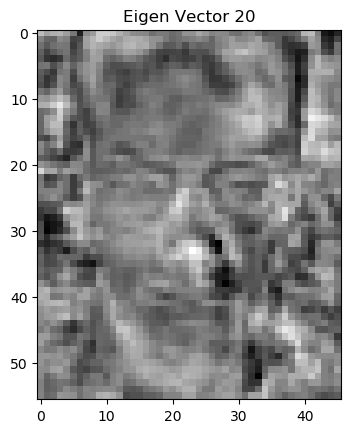

In [791]:
for i in range(0, 21):
    printImage(W_opt[:, i], "Eigen Vector "+str(i), "reconstructed_face2.png")

### 5. NN Classification

In [792]:
W_train = np.matmul(X_train, W_opt) #calculate weights of training data
W_test = np.dot(X_test, W_opt) #calculate weights of the test data 

In [793]:
accuracy = NNClassification_weights(W_train, W_test, y_train, y_test)
accuracy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [1156]:
random.randint(0,7)

5

# PCA-LDA Ensemble

In [1159]:
import random

def basic_bagging(images, c1): #implements bagging (with replacement)
    bagged_images = []
    for i in range(0, c1):
        rand_index = random.randint(0,6)
        bagged_images.append(images[rand_index])
    return bagged_images

def create_one_replicate(X_train, y_train, c1): #creates a single replicate containing c1 images from each of the 52 classes
    #X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
    replicate = np.empty((0, 2576))
    replicate_labels = []
    for class_i in range(1, 53):
        class_i_images = X_train[np.where(y_train == class_i)[0]]
        bagged_class_i = basic_bagging(class_i_images, c1)
        bagged_class_i = convert_list_to_numpy_array(bagged_class_i)
        replicate = np.concatenate((replicate, bagged_class_i), axis=0)
        for i in range(0,c1):
            replicate_labels.append(class_i)
    return replicate, replicate_labels

def convert_list_to_numpy_array(myList):
    myArray = np.array(myList)
    return myArray

X_train, y_train, N_train, X_test, y_test, N_test = extractTrainAndTestData(file_path, testRatio, r2)
def PCA_LDA_new(X_train, y_train, X_test, y_test, M_pca, M_lda):        
    #W_pca
    AvgFace, A_train, EigenValues, EigenSpace = calculateEigenSpace(X_train, M_pca)
    W_pca = EigenSpace
    
    #calculate S_w and S_b
    class_means = compute_class_means_(X_train, y_train)
    S_b = compute_S_b(class_means, M_pca)
    S_w = compute_S_w(class_means, M_pca)
    #W_lda
    W_lda = calculateGeneralisedEigenvectors(np.linalg.multi_dot([W_pca.T, S_w, W_pca]), np.linalg.multi_dot([W_pca.T, S_b, W_pca]), M_lda)
    
    #W_opt
    W_opt = np.matmul(W_lda.T, W_pca.T).T
    
    A_test = normalize(X_test, AvgFace)
    #Classification
    W_train = np.matmul(A_train.T, W_opt) #calculate weights of training data
    W_test = np.dot(A_test.T, W_opt) #calculate weights of the test data 
    neigh = NNClassification_weights(W_train, W_test, y_train, y_test)
    acc = neigh.score(W_test, y_test)
    return neigh.predict(W_test)

def calc_accuracy(predictions, y_test):
    return np.sum(predictions==np.squeeze(y_test))/len(y_test)*100

In [1246]:
M_pca = 145
M_lda = 48

c1 = 7
T = 20 #number of replicates

def baggingRand(X_train, y_train, X_test, y_test, c1, T, M_pca, M_lda):
    all_replicates = []
    all_replicates_labels = []
    
    #create all T replicates
    for i in range(0, T):
        replicate, replicate_labels = create_one_replicate(X_train, y_train, c1)
        #print(replicate.shape, len(replicate_labels))
        all_replicates.append(replicate)
        all_replicates_labels.append(replicate_labels)

    #apply PCA-LDA to each replicate
    all_predictions = np.empty((T, len(X_test)))
    for i in range(0, len(all_replicates)):
        this_replicate_classifier = PCA_LDA_new(np.array(all_replicates[i]), np.array(all_replicates_labels[i]), X_test, y_test, M_pca, M_lda)
        print(i)
        all_predictions[i] = this_replicate_classifier
        
    #apply majority voting to get majority predictions
    predictions = np.empty((len(X_test),))
    for i, row in enumerate(all_predictions.T):
        counts = np.bincount(row.astype(int))
        predictions[i] = np.argmax(counts)
        
    # return the score of the ensemble model
    acc = calc_accuracy(predictions, y_test)
    print('accuracy for c1=' + str(c1) + ' T=' + str(T) + ' M_pca=' + str(M_pca) + ' M_lda=' + str(M_lda) + ':', str(acc))
    return calc_accuracy(predictions, y_test), all_predictions, predictions

T=20
bagging_results = []
for c1 in range(3, 4):
    acc, all_predictions_bagging, bagging_predictions = baggingRand(X_train, y_train, X_test, y_test, c1, T, M_pca, M_lda)
    bagging_results.append(acc)

    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
accuracy for c1=3 T=20 M_pca=145 M_lda=48: 58.333333333333336


(156, 1)
(20, 156)


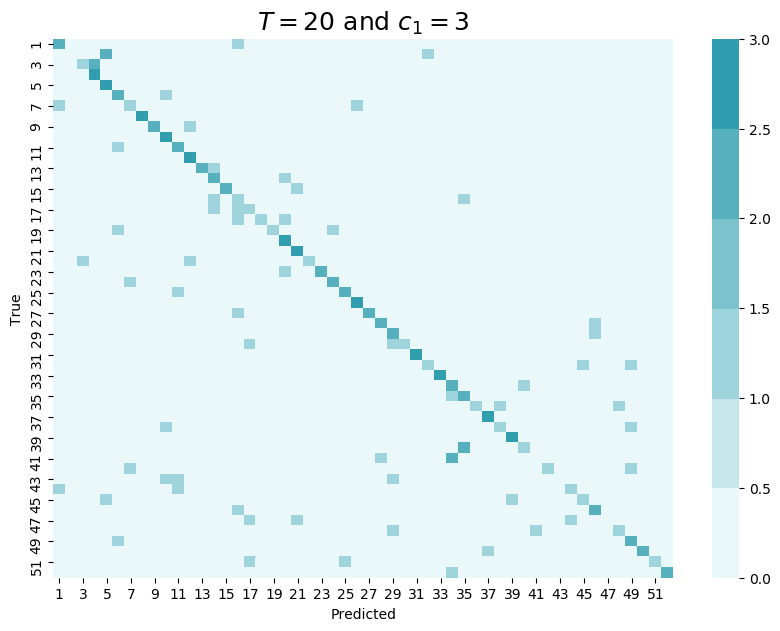

In [1248]:
def plot_conf_mat(y_test, y_predict):
    from sklearn.metrics import confusion_matrix
    cm2 = confusion_matrix(np.squeeze(y_test), np.squeeze(y_predict), range(1, 53)) 
    import pandas as pd
    import seaborn as sn
    figsize = (10, 7)
    df_cm = pd.DataFrame(cm2, index=range(1, 53), columns=range(1, 53))
    fig = plt.figure(figsize=figsize)
    heatmap = sn.heatmap(df_cm, cmap = sn.light_palette((210, 90, 60), input="husl"))
    plt.title('$T=20$ and $c_1=3$', fontsize=18)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig("baggingcmbad.png", bbox_inches='tight', dpi=300)   # save the figure to file
    plt.show()
    plt.close()


bagging_predictions = np.empty((len(X_test),))
for i, row in enumerate(all_predictions_bagging.T):
    counts = np.bincount(row.astype(int))
    bagging_predictions[i] = np.argmax(counts)

print(y_test.shape)
print(all_predictions_bagging.shape)
plot_conf_mat(y_test, bagging_predictions)

In [1245]:
import copy
a = copy.deepcopy(bagging_predictions)
a.shape

(156,)

In [1115]:
len(all_replicates_labels[1])

312

In [1121]:
predictions = np.empty((len(X_test),))
for i, row in enumerate(all_predictions.T):
    counts = np.bincount(row.astype(int))
    predictions[i] = np.argmax(counts)
predictions
calc_accuracy(predictions, y_test)

75.0

In [679]:
all_predictions.shape

(20, 156)

In [226]:
print(np.sum(predictions==np.squeeze(y_test))/len(y_test)*100)

70.51282051282051


#### Feature randomisation

In [1195]:
def pickM1RandomEigenvectors(eigenvectors, M1):
    total_number = eigenvectors.shape[1] #total number of eigenvectors
    indices = np.random.choice(total_number, size=M1, replace=False)
    return eigenvectors[:,indices]

def compute_class_means_(X_train, y_train):
    class_means={} #dict containing m1, m2, m3, ... (the mean of each class), as well as the global mean m
    for class_i in range(1, 53):
        class_means["m_" + str(class_i)] = np.mean(X_train[np.where(y_train == class_i)[0]], axis=0)
    class_means["m"] = calculateAverageFace(X_train)
    return class_means

In [1201]:
#Steps:
    #Apply PCA to training set
    #Generate T random subspaces (each having M0+M1 eigenfaces)
    #Construct an LDA classifier from the T random subspaces (with Mpca=M0+M1 and Mlda varying)
    

def featureRand(EigenSpace, M0, M1, T, M_lda):
    topM0eigenvectors, remainingEigenvectors = np.split(EigenSpace, [M0], axis=1)
    #print(EigenSpace)
    #print(topM0eigenvectors)
    #print(remainingEigenvectors)
    #LDA: calculate S_w and S_b
    #class_means = compute_class_means_(X_train, y_train)
    #S_b = compute_S_b(class_means, M0+M1)
    #S_w = compute_S_w(class_means, M0+M1)
    
    #print(np.linalg.matrix_rank(S_b), np.linalg.matrix_rank(S_w))

    all_W_opt = []
    for i in range(0, T):
        extraEigenvectors = pickM1RandomEigenvectors(remainingEigenvectors, M1)
        newRandomisedEigenspace = np.concatenate((topM0eigenvectors, extraEigenvectors), axis=1)

        #computation of W_pca.T*S_b*W_pca
        numerator = np.linalg.multi_dot([newRandomisedEigenspace.T, S_b, newRandomisedEigenspace])
        #computation of W_pca.T*S_w*W_pca
        denominator = np.linalg.multi_dot([newRandomisedEigenspace.T, S_w, newRandomisedEigenspace])

        W_lda = calculateGeneralisedEigenvectors(denominator, numerator, M_lda)
        W_opt = np.matmul(W_lda.T, newRandomisedEigenspace.T).T
        all_W_opt.append(W_opt)
    return all_W_opt #a list of length T containing the W_opt of each of the T models

def classifySubspace(W_opt):
    #Classification
    W_train = np.matmul(A_train.T, W_opt) #calculate weights of training data
    W_test = np.dot(A_test.T, W_opt) #calculate weights of the test data 
    #print(len(y_train), W_train.shape)
    neigh = NNClassification_weights(W_train, W_test, y_train, y_test)
    acc = neigh.score(W_test, y_test)
    #print(acc)
    return neigh.predict(W_test), acc

In [1216]:
#M=363
AvgFace, A_train, EigenValues, EigenSpace = calculateEigenSpace(X_train, M)
A_test = normalize(X_test, AvgFace)

M0=10
M1=98
T=20
M_lda=48

class_means = compute_class_means_(X_train, y_train)
S_b = compute_S_b(class_means, M0+M1)
S_w = compute_S_w(class_means, M0+M1)

for M0 in [100]:
    M1 = 145-M0
    all_W_opt = featureRand(EigenSpace, M0, M1, T, M_lda)

    all_predictions_featureRand = np.empty((T, len(X_test)))
    avg_acc = []
    for index, W_opt in enumerate(all_W_opt):
        all_predictions_featureRand[index], model_acc = classifySubspace(W_opt)
        avg_acc.append(model_acc)
    avg_acc = np.mean(avg_acc)

    predictions_featureRand = np.empty((len(X_test),))
    #print(all_predictions_featureRand[0])
    for i, row in enumerate(all_predictions_featureRand.T):
        counts = np.bincount(row.astype(int))
        predictions_featureRand[i] = np.argmax(counts)
        #print(counts)
    print('accuracy for M0=' + str(M0) + ' M1=' + str(M1) + ' T=' + str(T) + ' M_lda=' + str(M_lda) + ':', str(calc_accuracy(predictions_featureRand, y_test)), 'avg_acc:', 100*avg_acc)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


accuracy for M0=100 M1=45 T=20 M_lda=48: 70.51282051282051 avg_acc: 70.22435897435896


In [ ]:
accuracy for M0=50 M1=150 T=20 M_lda=51: 69.87179487179486
accuracy for M0=100 M1=100 T=20 M_lda=51: 71.15384615384616
accuracy for M0=150 M1=50 T=20 M_lda=51: 72.43589743589743

In [1217]:
all_preds_combined = np.concatenate((all_predictions_bagging, all_predictions_featureRand))

all_preds = np.empty((len(X_test),))
for i, row in enumerate(all_preds_combined.T):
    counts = np.bincount(row.astype(int))
    all_preds[i] = np.argmax(counts)
calc_accuracy(all_preds, y_test)

71.15384615384616

In [701]:
def printTopImages(title, saved_file):
    """
    takes input as the face you want to print, the title of the image, and the location of the file
    you would like to save the image to. 
    """
    plt.figure()
    plt.imshow(np.resize(face, (46, 56)).T, cmap='gray')
    plt.title(title)
    plt.savefig(saved_file, bbox_inches='tight')   # save the figure to file
    plt.show()
    plt.close()
    
printTopImages("", 'topimages.png')

NameError: name 'face' is not defined